<a href="https://colab.research.google.com/github/mohamadhabash/Tweets-Sentiment-Analysis-using-RoBERTa/blob/main/Tweets_Sentiment_Analysis_using_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Requirements

In [ ]:
!pip install transformers
!pip install shutup

#Setup and Config

In [ ]:
import shutup; shutup.please()
import pandas as pd
import numpy as np
import torch

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#Datasets retrieve

Datasets Source: https://www.kaggle.com/c/tweet-sentiment-extraction

In [ ]:
!gdown --id 1c4jKy5AIS-5oISB1ObT5tKZEo2IM8TQF # train.csv
!gdown --id 1Kgr9D5Fmu8AyyG-v2b0gMvNa-rKHhcF3 # test.csv

# Data preprocessing

In [ ]:
df_train = pd.read_csv('/content/train.csv', index_col=0)
df_test = pd.read_csv('/content/test.csv', index_col=0)

df_train.head()

,text,selected_text,sentiment
textID,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
088c60f138,my boss is bullying me...,bullying me,negative
9642c003ef,what interview! leave me alone,leave me alone,negative
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, test_size=0.13, random_state=RANDOM_SEED)

In [ ]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

23908
3573
3534


In [ ]:
def create_label(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

df_train['score'] = df_train.sentiment.apply(create_label)
df_test['score'] = df_test.sentiment.apply(create_label)
df_val['score'] = df_val.sentiment.apply(create_label)

df_train.head()

,text,selected_text,sentiment,score
textID,,,,
77a1abb2ba,mom just woke me u[p and i am so mad i was dre...,o stupid,negative,0
11a05040a9,you okay bby?,you okay bby?,neutral,1
0a4cc4c868,"had to pause tv, now i`m 10 minutes behind on BGT","had to pause tv, now i`m 10 minutes behind on BGT",neutral,1
c5fbcd3afa,u no there was no point pointing it out yeste...,they were kinda pissed,negative,0
c1608cfd9d,I want an iPhone <33333,I want an iPhone <33333,positive,2


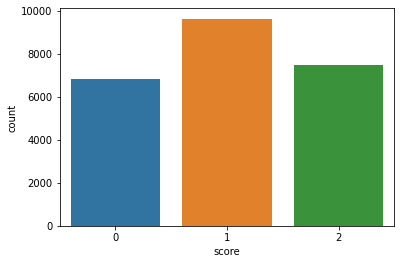

In [ ]:
import seaborn as sns
sns.countplot(df_train.score, x=['negative','neutral','positive'])

#Encoding Example

In [ ]:
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
sample_txt = 'Hello, How are you? I am under the water, Please help me! sfosd'
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

In [ ]:
print('Special Tokens')
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

Special Tokens
</s> 2
<s> 0
<pad> 1
<unk> 3


In [ ]:
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

tensor([    0, 31414,     6,  1336,    32,    47,   116,    38,   524,   223,
            5,   514,     6,  3401,   244,   162,   328,   579,   506,   366,
          417,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


# Choose maximum sequence length

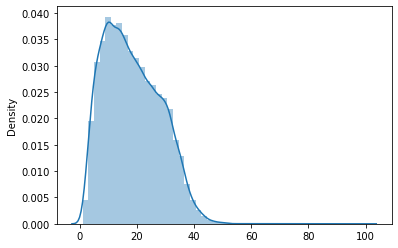

In [ ]:
token_lens = []

def calculate_seq_length(df):
  for txt in df.text:
    tokens = tokenizer.tokenize(str(txt))
    token_lens.append(len(tokens))

calculate_seq_length(df_train)
calculate_seq_length(df_val)
calculate_seq_length(df_test)

sns.distplot(token_lens)

#Creating Dataset & Dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

class TwitterDataset(Dataset):

  def __init__(self, text, score, tokenizer, max_len):
    self.text = text
    self.score = score
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text[index])
    score = self.score[index]

    encoding = tokenizer.encode_plus(
        text,
        max_length=self.max_len,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )

    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'score': torch.tensor(score, dtype=torch.long)
    }

In [ ]:
MAX_LEN=64
BATCH_SIZE = 32 # BERT paper suggests a batch size of 16 or 32
EPOCHS = 10
n_classes=3

In [ ]:
def create_dataloader(df, tokenizer, max_len, batch_size):
  ds = TwitterDataset(text=df.text.to_numpy(),
                      score=df.score.to_numpy(),
                      tokenizer=tokenizer,
                      max_len=max_len)
  return DataLoader(ds,
                    batch_size=batch_size,
                    num_workers=2)

In [ ]:
train_data_loader = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

#Batch example

In [ ]:
batch_example = next(iter(train_data_loader))

print(batch_example['input_ids'][0])
print(batch_example['text'][13])
print(batch_example['attention_mask'][0])
print(batch_example['score'][0])

tensor([    0, 27363,    95, 13356,   162,  1717, 10975,   642,     8,   939,
          524,    98,  7758,   939,    21, 26240,    59,  1437,  5582,  1437,
           79,  8401,  3277,   162,     7,   213,     7,     5,  4908,    24,
           16,    98, 12103,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])
Sunburnt  Gutted! Hope it`s faded by tmw!
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0)


In [ ]:
batch_example['input_ids'].shape

torch.Size([32, 64])

#BERT Demo (using one sequence)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# [batch_size, max_seq_length, 768], 768 dimension embedding for each token in the given sentence
# Pooler output will give output of dimension [1, 1, 768]--> [1, 768], which is the embedding of [CLS] token.
# In general people use 'pooled output' of the sentence and use it for text classification

last_hidden_state, pooled_output = roberta_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    return_dict=False
)
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


In [ ]:
roberta_model.config.hidden_size

768

#Building Model

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.roberta.config.hidden_size, n_classes) # [768, 3]

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.roberta(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    
    return output

In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

# Applying the model on a batch example (before training)

In [ ]:
input_ids = batch_example['input_ids'].to(device)
attention_mask = batch_example['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 64])
torch.Size([32, 64])


In [ ]:
batch_example['score']

tensor([0, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2, 1, 2,
        1, 0, 1, 2, 2, 0, 0, 2])

In [ ]:
outputs = model(input_ids, attention_mask)
outputs_probs = F.softmax(outputs, dim=1)
_, preds = torch.max(outputs_probs, dim=1)

print(outputs[:11], '\n')
print(outputs_probs[:11],'\n')
print(preds)

tensor([[-0.0137,  0.0088,  0.0076],
        [-0.1180, -0.0731,  0.0824],
        [-0.1881,  0.0666,  0.0096],
        [-0.2474,  0.0179, -0.0168],
        [-0.2282,  0.0486,  0.0847],
        [-0.2030,  0.0230,  0.1271],
        [-0.1979,  0.0312,  0.1135],
        [ 0.0340,  0.1031,  0.1026],
        [-0.2537,  0.1157, -0.0039],
        [-0.1634, -0.0984,  0.0218],
        [-0.1094,  0.0880,  0.0826]], device='cuda:0', grad_fn=<SliceBackward>) 

tensor([[0.3285, 0.3360, 0.3356],
        [0.3060, 0.3201, 0.3739],
        [0.2850, 0.3677, 0.3473],
        [0.2806, 0.3659, 0.3534],
        [0.2713, 0.3578, 0.3709],
        [0.2744, 0.3440, 0.3817],
        [0.2760, 0.3471, 0.3769],
        [0.3182, 0.3410, 0.3408],
        [0.2681, 0.3878, 0.3441],
        [0.3057, 0.3263, 0.3680],
        [0.2916, 0.3552, 0.3533]], device='cuda:0', grad_fn=<SliceBackward>) 

tensor([1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 1, 2, 1, 1, 2], device='cuda:0')

#Training Model

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) # Same as BERT paper

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Same as BERT paper
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
from tqdm.auto import tqdm

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model = model.train()

  losses = []
  correct_predictions = 0

  for batch in tqdm(data_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    score = batch['score'].to(device)

    outputs = model(
        input_ids,
        attention_mask=attention_mask
    )

    _, preds = torch.max(F.softmax(outputs), dim=1)
    loss = loss_fn(outputs, score)

    correct_predictions += torch.sum(preds == score)
    losses.append(loss.item())

    loss.backward() # Compute dloss/dx for every parameter x
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # A way to combat exploding gradients (gradients becoming too large), similar to BERT paper
    optimizer.step() # Update parameters
    scheduler.step() # Reduce learning rate
    
    """
     Zero out gradients so that you do the parameter update correctly. 
     Else the gradient would point in some other direction than towards minumum
     We do this because by default loss.backward() accumulates gradients 
    """
    optimizer.zero_grad()

  accuracy = correct_predictions.double() / n_examples
  loss = np.mean(losses)

  return accuracy, loss

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad(): # Disable gradient functions so torch is faster
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      score = batch['score'].to(device)

      outputs = model(
          input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(F.softmax(outputs), dim=1)
      loss = loss_fn(outputs, score)

      correct_predictions += torch.sum(preds == score)
      losses.append(loss.item())
  
    accuracy = correct_predictions.double() / n_examples
    loss = np.mean(losses)

  return accuracy, loss

In [ ]:
print(len(df_train))
print(len(df_val))

23908
3573


In [ ]:
#%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train) )

  print(f'Train loss {train_loss} Train accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model=model,
      data_loader=val_data_loader,
      loss_fn=loss_fn,
      device=device,
      n_examples=len(df_val)
  )

  print(f'Val   loss {val_loss} Val accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/748 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train loss 0.6084278605997882 Train accuracy 0.7450644135854108


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val   loss 0.530412263369986 Val accuracy 0.7847746991323817

Epoch 2/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/748 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train loss 0.44444199763039216 Train accuracy 0.8241174502258658


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val   loss 0.5296663297340274 Val accuracy 0.7872935908200392

Epoch 3/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/748 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train loss 0.361889141285543 Train accuracy 0.8625564664547432


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val   loss 0.5884697169863752 Val accuracy 0.7850545759865659

Epoch 4/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/748 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train loss 0.2962810837422164 Train accuracy 0.8904132507947131


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val   loss 0.6570540078516517 Val accuracy 0.7766582703610412

Epoch 5/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/748 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train loss 0.23817628772959193 Train accuracy 0.9181027271206291


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val   loss 0.7125251129535692 Val accuracy 0.7800167926112511

Epoch 6/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/748 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train loss 0.19828770818365588 Train accuracy 0.9348335285260164


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Val   loss 0.8076990704451289 Val accuracy 0.7772180240694095

Epoch 7/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/748 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


KeyboardInterrupt: ignored

#Evaluation

In [ ]:
model = SentimentClassifier(3)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state.bin'))
model = model.to(device)

test_acc, test_loss =  eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select thi

tensor(0.7915, device='cuda:0', dtype=torch.float64)